In [41]:
import numpy as np
import pandas as pd
import subprocess
import sys
from pyearth import Earth
import tempfile
import shutil
import os
os.environ["DATA_PATH"] = "/root/work/data"
from sklearn.datasets import make_swiss_roll
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import load_digits
from lasagnekit.datasets.mnist import MNIST
%matplotlib inline

In [89]:
def packing_dim(D, r1, r2, eps=1e-3, min_iter=10, max_iter=100, random_state=42, verbose=1):
    """
    Figure 2 of the paper
    """
    assert min_iter > 1
    nb_examples = len(D)
    rng = np.random.RandomState(random_state)
    n = X.shape[0]
    r = {1: r1, 2: r2}
    L_mean = {1: 0., 2: 0.}
    L_sqr_mean = {1: 0., 2: 0.}
    D_orig = D
    L = {1: [], 2: []}
    for l in range(max_iter):
        indices = np.arange(nb_examples)
        rng.shuffle(indices)        
        D = D_orig[indices]
        D = D[:, indices]
        
        for k in (1, 2):
            C = []
            for i in range(n):
                include = True
                for c in C:
                    if D[i, c] < r[k]:
                        include = False
                        break
                if include:
                    C.append(i)
            L_mean[k] = (np.log(len(C)) + l * L_mean[k]) / (l + 1)
            L_sqr_mean[k] = (np.log(len(C))**2 + l * L_sqr_mean[k]) / (l + 1)
    
        dpack = -(L_mean[2] - L_mean[1]) / (np.log(r[2]) - np.log(r[1]))
        var1 = L_sqr_mean[1] - L_mean[1] ** 2
        var2 = L_sqr_mean[2] - L_mean[2] ** 2
        #var1 = np.var(L[1])
        #var2 = np.var(L[2])
        var = {1: var1, 2: var2}
        if l >= min_iter and close_enough(dpack, l, r, var, L_mean, L_sqr_mean, eps=eps):
            if verbose > 0:
                print('Finishing after getting close enough approximation of dpack')
            break
    return dpack

def close_enough(dpack, l, r, var, L_mean, L_sqr_mean, eps=1e-3):
    assert l > 0
    r1, r2 = r[1], r[2]
    var1, var2 = var[1], var[2]
    
    if np.abs(var1-var2) <= 1e-5:
        dpack_lb = 0
    else:
        dpack_lb = 1.65 * (np.sqrt(var1 + var2) / (np.sqrt(l + 1) * (np.log(r2) - np.log(r1)))) * 2 / (1 - eps)
    return dpack > dpack_lb

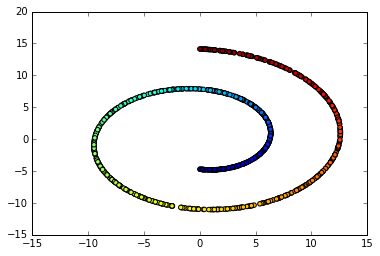

In [43]:
X, labels = make_swiss_roll(1000)
plt.scatter(X[:, 0], X[:, 2], c=labels)

In [106]:
#data= load_digits()
#X = data['data']
data = MNIST()
data.load()
X = data.X[0:1000]

In [124]:
Y = np.random.normal(0, 1, size=(5000, 14))
W = np.random.normal(0, 1, size=(14, 200))
X = np.dot(Y, W)
print(X.shape)

(5000, 200)


In [125]:
D = pairwise_distances(X)

(array([  5.00200000e+03,   1.24160000e+04,   8.06948000e+05,
          5.99684600e+06,   1.05135480e+07,   6.08106200e+06,
          1.42102600e+06,   1.53996000e+05,   8.87000000e+03,
          2.86000000e+02]),
 array([   0.        ,   16.11615742,   32.23231484,   48.34847227,
          64.46462969,   80.58078711,   96.69694453,  112.81310195,
         128.92925937,  145.0454168 ,  161.16157422]),
 <a list of 10 Patch objects>)

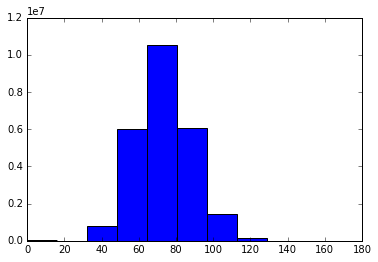

In [126]:
plt.hist(D.flatten())

In [ ]:
r = np.linspace(max(D.min(), 10), D.max(), 100)
r_avg = 0.5 * (r[0:-1] + r[1:])
dpacks = []
for r1, r2 in tqdm(zip(r[0:-1], r[1:])):
    dpack = packing_dim(D, r1, r2, verbose=1, max_iter=100, eps=1e-2)
    dpacks.append(dpack)

  0%|          | 0/99 [00:00<?, ?it/s]

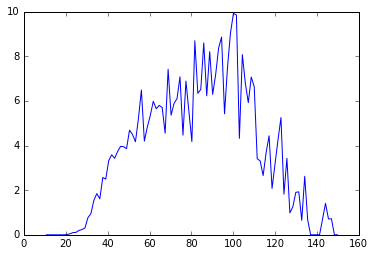

In [121]:
plt.plot(r_avg, dpacks)

In [122]:
print(np.mean(dpacks))

3.69161229706


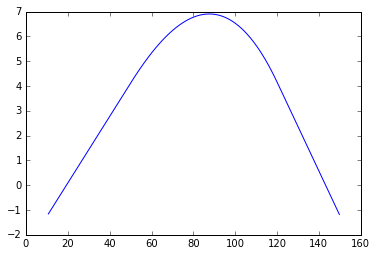

In [123]:
earth = Earth(smooth=True)
earth.fit(r_avg, dpacks)
plt.plot(r_avg, earth.predict(r_avg))
#plt.plot(r_avg, earth.predict_deriv(r_avg)[:, :, 0])